# Modeling repertoire growth

In [65]:
%matplotlib inline

import os,re,glob,datetime
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')
sns.set_context('talk')

## Define epochs

Find time of first map seed:

In [3]:
seed_file = '../3_technology/outputs/seed_changes.txt'
with open(seed_file, 'r') as seed_handle:
    seeds = seed_handle.read().splitlines()
    
seeds = [int(s) for s in seeds]
start_t = seeds[0]
print('First seed: %i' % start_t)
print(datetime.datetime.fromtimestamp(start_t))

First seed: 1573895673
2019-11-16 09:14:33


Load all families:

In [7]:
family_df = pd.read_csv('../2_demographics/outputs/family_playerID.tsv', sep='\t', index_col=0)
family_df.head()

/users/nvelezalicea/.conda/envs/py3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,avatar,family
0,3308592,time-1599460982_eve-3308568_name-SOL
1,3308568,time-1599460982_eve-3308568_name-SOL
2,3308504,time-1599458188_eve-3308504_name-SOL
3,3308439,time-1599456178_eve-3308427_name-MORALES
4,3308507,time-1599456178_eve-3308427_name-MORALES


Get families included in analysis:

In [45]:
success_df = pd.read_csv('../2_demographics/outputs/family_fitness.tsv', sep='\t')
included_families = success_df['family'].values

Load lifelogs during time period studied:

In [47]:
life_df = pd.read_csv('../2_demographics/outputs/all_lifelogs_compact.tsv', sep='\t', index_col=0)
life_df = life_df[life_df['tBirth'] >= start_t]
life_df = life_df.dropna(subset=['tDeath'])
life_df = pd.merge(life_df, family_df, how='left')
life_df = life_df[life_df['family'].isin(included_families)]
life_df = life_df.sort_values(by=['family', 'tBirth'])
life_df = life_df.reset_index(drop=True)
life_df.head()

,player,avatar,tBirth,parent,birth,tDeath,death,age,cause_of_death,birthX,birthY,deathX,deathY,first,last,family
0,6290670c4fe41726873b54d070b869fdcc9e06e7,2276905,1573895755,-1,[-5130 -1397],1.573899e+09,[-5130 -1383],60.00,oldAge,-5130,-1397,-5130.0,-1383.0,EVE,ZABICKI,time-1573895755_eve-2276905_name-ZABICKI
1,d74e306b2dc466835e85acf5b53a4391e2346857,2276906,1573895772,2276905,[-5128 -1392],1.573896e+09,[-5106 -1403],10.05,hunger,-5128,-1392,-5106.0,-1403.0,KOKO,ZABICKI,time-1573895755_eve-2276905_name-ZABICKI
2,b0527ef2371111cb11369f4a5fe021c1bdb06ed9,2276909,1573895873,2276905,[-5121 -1398],1.573899e+09,[-5107 -1389],45.99,murdered,-5121,-1398,-5107.0,-1389.0,MASA,ZABICKI,time-1573895755_eve-2276905_name-ZABICKI
3,e417361f8e2770a2a5647353af05f6e621be69c0,2276914,1573895976,2276905,[-5133 -1397],1.573898e+09,[-5122 -1400],41.77,murdered,-5133,-1397,-5122.0,-1400.0,NYANA,ZABICKI,time-1573895755_eve-2276905_name-ZABICKI
4,86e9bd89d9b9fd7593375c84bc6c4ef54b46745a,2276920,1573896220,2276905,[-5108 -1419],1.573896e+09,[-5108 -1419],0.30,disconnect,-5108,-1419,-5108.0,-1419.0,KONOR,ZABICKI,time-1573895755_eve-2276905_name-ZABICKI


How many seconds are in 20 minutes?

In [48]:
interval = 20*60
print('Interval: %i seconds' % interval)

Interval: 1200 seconds


Split up each family's history into epochs of 20 minutes:

In [64]:
def get_intervals(row): return np.linspace(row['start'], row['end'], row['n_tpoints']).astype(np.int)

# Get total duration
epoch_df = life_df.groupby('family').agg({'tBirth': 'min', 'tDeath': 'max'}).reset_index()
epoch_df = epoch_df.rename(columns={'tBirth': 'start', 'tDeath': 'end_raw'})
epoch_df['dur'] = epoch_df['end_raw'] - epoch_df['start']

# Round up end of family line to next 20-minute interval
epoch_df['dur_rounded'] = np.ceil(epoch_df['dur']/interval)*interval
epoch_df['end'] = epoch_df['start'] + epoch_df['dur_rounded']
epoch_df['end'] = epoch_df['end'].astype(np.int)

# Number of timepoints
epoch_df['n_tpoints'] = epoch_df['dur_rounded']/interval + 1
epoch_df['n_tpoints'] = epoch_df['n_tpoints'].astype(np.int)
epoch_df['log_n'] = np.log10(epoch_df['n_tpoints'])

# Get timepoints
epoch_df['tpoints'] = epoch_df.apply(get_intervals, axis=1)
epoch_df.head()

,family,start,end_raw,dur,dur_rounded,end,n_tpoints,log_n,tpoints
0,time-1573895755_eve-2276905_name-ZABICKI,1573895755,1.573899e+09,3539.0,3600.0,1573899355,4,0.602060,"[1573895755, 1573896955, 1573898155, 1573899355]"
1,time-1573895904_eve-2276911_name-ROHRER,1573895904,1.573897e+09,707.0,1200.0,1573897104,2,0.301030,"[1573895904, 1573897104]"
2,time-1573896101_eve-2276917_name-BADA,1573896101,1.573904e+09,7483.0,8400.0,1573904501,8,0.903090,"[1573896101, 1573897301, 1573898501, 157389970..."
3,time-1573896134_eve-2276919_name-SARINA,1573896134,1.573907e+09,11006.0,12000.0,1573908134,11,1.041393,"[1573896134, 1573897334, 1573898534, 157389973..."
4,time-1573896495_eve-2276927_name-LISSADE,1573896495,1.573970e+09,73999.0,74400.0,1573970895,63,1.799341,"[1573896495, 1573897695, 1573898895, 157390009..."


Number of timepoints contained in each family:

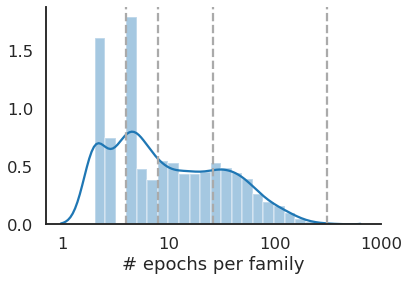

In [73]:
q_n = scipy.stats.mstats.mquantiles(epoch_df['log_n'], np.linspace(0.25,1,4))

# Plot distribution
ax = sns.distplot(epoch_df['log_n'])
ax.set(xticks = range(4), xticklabels = [10**x for x in range(4)],
       xlabel = '# epochs per family')
sns.despine()

for q in q_n:
    plt.axvline(q, color='#aaaaaa', linestyle='--')

## Proof of concept: Pick some average families

In [97]:
middle_df = epoch_df[(epoch_df['log_n'] >= q_n[1]) & (epoch_df['log_n'] < q_n[2])]
middle_df = middle_df.sort_values(by = 'log_n', ascending=False)
middle_df = middle_df.reset_index(drop=True)
middle_df = middle_df.head(10)
middle_df = middle_df[['family', 'n_tpoints', 'tpoints']]

middle_families = list(np.unique(middle_df['family']))

print(middle_families)
middle_df

['time-1575176970_eve-2356439_name-BLACK', 'time-1575479967_eve-2370998_name-PERRY', 'time-1576231604_eve-2406684_name-LOVELY', 'time-1576586684_eve-2425739_name-SINCLAIR', 'time-1576682299_eve-2430993_name-FEUER', 'time-1576817215_eve-2438182_name-ANGON', 'time-1578317678_eve-2533399_name-DIAMOND', 'time-1589589117_eve-3000219_name-SLINKMAN', 'time-1591477888_eve-3054230_name-GA', 'time-1593788344_eve-3135807_name-FREYLER']


,family,n_tpoints,tpoints
0,time-1576231604_eve-2406684_name-LOVELY,25,"[1576231604, 1576232804, 1576234004, 157623520..."
1,time-1589589117_eve-3000219_name-SLINKMAN,25,"[1589589117, 1589590317, 1589591517, 158959271..."
2,time-1576586684_eve-2425739_name-SINCLAIR,25,"[1576586684, 1576587884, 1576589084, 157659028..."
3,time-1575479967_eve-2370998_name-PERRY,25,"[1575479967, 1575481167, 1575482367, 157548356..."
4,time-1576682299_eve-2430993_name-FEUER,25,"[1576682299, 1576683499, 1576684699, 157668589..."
5,time-1576817215_eve-2438182_name-ANGON,25,"[1576817215, 1576818415, 1576819615, 157682081..."
6,time-1591477888_eve-3054230_name-GA,25,"[1591477888, 1591479088, 1591480288, 159148148..."
7,time-1575176970_eve-2356439_name-BLACK,25,"[1575176970, 1575178170, 1575179370, 157518057..."
8,time-1593788344_eve-3135807_name-FREYLER,25,"[1593788344, 1593789544, 1593790744, 159379194..."
9,time-1578317678_eve-2533399_name-DIAMOND,25,"[1578317678, 1578318878, 1578320078, 157832127..."


Success metrics? 

In [94]:
middle_success = pd.merge(middle_families, success_df, on='family', how='left')
middle_success = middle_success[['family', 'n_tpoints', 'dur', 'sum', 'count', 'beta_mean', 'longest_path']]
middle_success['dur'] = np.round(middle_success['dur']/60/60, 2)
middle_success = middle_success.rename(columns={'sum': 'total_size', 'count': 'viability'})
middle_success

,family,n_tpoints,dur,total_size,viability,beta_mean,longest_path
0,time-1576231604_eve-2406684_name-LOVELY,25,7.80,109,142,0.756757,17
1,time-1589589117_eve-3000219_name-SLINKMAN,25,7.78,96,131,0.722628,18
2,time-1576586684_eve-2425739_name-SINCLAIR,25,7.75,107,139,0.758621,18
3,time-1575479967_eve-2370998_name-PERRY,25,7.82,92,116,0.778689,20
4,time-1576682299_eve-2430993_name-FEUER,25,7.85,109,147,0.732026,18
5,time-1576817215_eve-2438182_name-ANGON,25,7.73,66,95,0.683168,16
6,time-1591477888_eve-3054230_name-GA,25,7.67,82,112,0.720339,16
7,time-1575176970_eve-2356439_name-BLACK,25,7.94,71,88,0.787234,21
8,time-1593788344_eve-3135807_name-FREYLER,25,7.90,77,129,0.592593,19
9,time-1578317678_eve-2533399_name-DIAMOND,25,7.97,124,159,0.769697,20


Sample size:

In [100]:
middle_life = life_df[life_df['family'].isin(middle_families)]
middle_sample = middle_life[['family', 'player', 'avatar']].nunique()

Color palette

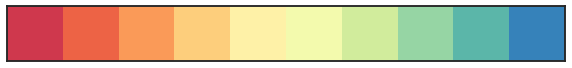

In [186]:
colors = sns.color_palette('Spectral', 10)
middle_pal = {k:v for k,v in zip(middle_families, colors)}
sns.palplot(colors)

## Population size over time

### Moment-by-moment

In [187]:
living_list = []

for name, group in middle_life.groupby('family'):
    t = group['tBirth'].values
    for ti in t:
        is_alive = (group['tBirth'] <= ti) & (group['tDeath'] > ti)
        pop = np.sum(is_alive)
        living_list.append((name, ti, pop))

In [188]:
living_df = pd.DataFrame(living_list, columns = ['family', 't', 'population'])
living_df = living_df.sort_values(by=['family', 't'], ascending=True).reset_index(drop=True)
living_df['t0'] = living_df.groupby('family')['t'].transform('first')
living_df['t_elapsed'] = (living_df['t'] - living_df['t0'])/60/60
living_df.head()

,family,t,population,t0,t_elapsed
0,time-1575176970_eve-2356439_name-BLACK,1575176970,1,1575176970,0.000000
1,time-1575176970_eve-2356439_name-BLACK,1575177008,2,1575176970,0.010556
2,time-1575176970_eve-2356439_name-BLACK,1575177198,3,1575176970,0.063333
3,time-1575176970_eve-2356439_name-BLACK,1575177492,3,1575176970,0.145000
4,time-1575176970_eve-2356439_name-BLACK,1575177955,4,1575176970,0.273611


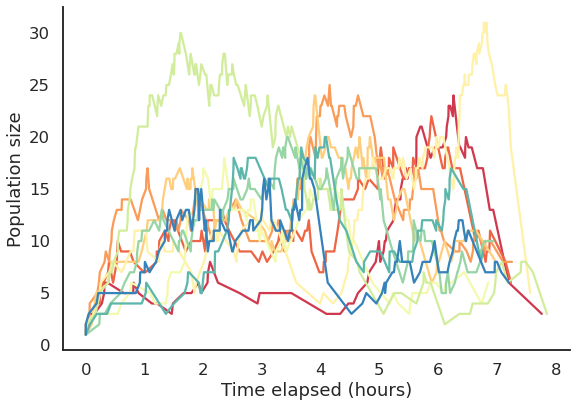

In [189]:
g = sns.relplot(data=living_df, x='t_elapsed', y='population', hue='family', kind='line',
                 height=6, aspect=1.5, palette=middle_pal)
g.set(xlabel = 'Time elapsed (hours)', ylabel = 'Population size')
g._legend.remove()

### Split into 20-minute chunks

In [157]:
epoch_list = []
for _,row in middle_df.iterrows():
    # row = middle_df.iloc[0]
    fam = middle_life[middle_life['family'] == row['family']].copy()
    t = list(row['tpoints'])

    for idx,tstart in enumerate(t[:-1]):
        tend = t[idx+1]

        died = np.sum((fam['tBirth'] < tstart) & (fam['tDeath'] >= tstart))
        born = np.sum((fam['tBirth'] >= tstart) & (fam['tBirth'] < tend))
        #lived = np.sum((fam['tBirth'] >= tstart) & (fam['tDeath'] < tend))

        epoch_list.append((row['family'], idx, tstart, tend, died, born, died+born))
        
epoch_df = pd.DataFrame(epoch_list, columns=['family', 'epoch', 'start', 'end', 'n_died', 'n_born', 'population'])
epoch_df['t_elapsed'] = epoch_df['epoch']*1/3
epoch_df.head()

,family,epoch,start,end,n_died,n_born,population,t_elapsed
0,time-1576231604_eve-2406684_name-LOVELY,0,1576231604,1576232804,0,8,8,0.000000
1,time-1576231604_eve-2406684_name-LOVELY,1,1576232804,1576234004,8,10,18,0.333333
2,time-1576231604_eve-2406684_name-LOVELY,2,1576234004,1576235204,13,5,18,0.666667
3,time-1576231604_eve-2406684_name-LOVELY,3,1576235204,1576236404,14,6,20,1.000000
4,time-1576231604_eve-2406684_name-LOVELY,4,1576236404,1576237604,13,8,21,1.333333


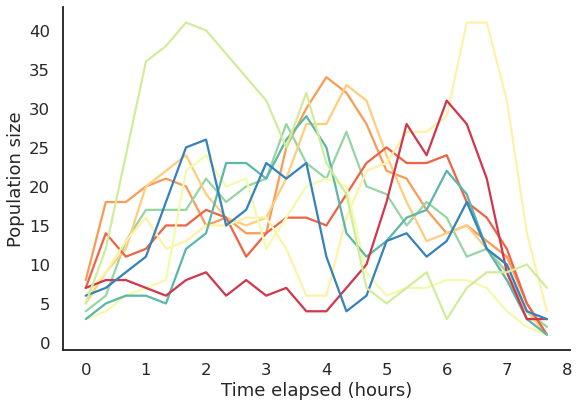

In [174]:
g = sns.relplot(data=epoch_df, x='t_elapsed', y='population', hue='family', kind='line',
                 height=6, aspect=1.5, palette=middle_pal)
g.set(xlabel = 'Time elapsed (hours)', ylabel = 'Population size')
g._legend.remove()

## Repertoire size over time